In [37]:
#initialize packages 


import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import scipy.stats as st

In [38]:
#load data 

data = pd.read_csv("modeldata_FINAL1.csv")


# Split the data into input features (X) and target variable (y)
X = data.drop('Activity', axis=1)  # Input features
X = X.iloc[:, 2:]
#X = X.drop("Unnamed: 24", axis=1)
#X = X.drop("human", axis = 1)
#X= X[:10000]
y = data['Activity'] # Target variable

feature_names = X.columns.values.tolist()
#print(feature_names)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9)

#print(X_test)


# Random grid search 

In [39]:
rfc = RandomForestClassifier(random_state=42)

print(rfc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [40]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 60)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 60)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True]

max_samples = [0.4,0.5,0.6,0.7,0.8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                'max_samples': max_samples}
print(random_grid)

{'n_estimators': [10, 16, 23, 29, 36, 43, 49, 56, 62, 69, 76, 82, 89, 95, 102, 109, 115, 122, 128, 135, 142, 148, 155, 162, 168, 175, 181, 188, 195, 201, 208, 214, 221, 228, 234, 241, 247, 254, 261, 267, 274, 281, 287, 294, 300, 307, 314, 320, 327, 333, 340, 347, 353, 360, 366, 373, 380, 386, 393, 400], 'max_features': ['sqrt'], 'max_depth': [10, 11, 13, 14, 16, 17, 19, 20, 22, 23, 25, 26, 28, 29, 31, 32, 34, 35, 37, 38, 40, 42, 43, 45, 46, 48, 49, 51, 52, 54, 55, 57, 58, 60, 61, 63, 64, 66, 67, 69, 71, 72, 74, 75, 77, 78, 80, 81, 83, 84, 86, 87, 89, 90, 92, 93, 95, 96, 98, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True], 'max_samples': [0.4, 0.5, 0.6, 0.7, 0.8]}


In [41]:

#https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance
#https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

#Initialize the model 

rfc = RandomForestClassifier(random_state=42)
k = 5

#Initialize the randomizedSeachCV using the parameter grid and model 
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 300, cv = k, verbose=0, random_state=42, n_jobs = -1)

X_train_val = X_train + X_valid
y_train_val = y_train + y_valid

# Fit the random search model
rfc_random.fit(X_train, y_train)

best_iteration_indices = []
parameters_for_grid = {'n_estimators': [],
               'max_features': [],
               'max_depth': [],
               'min_samples_split': [],
               'min_samples_leaf': [],
               'bootstrap': [],
                'max_samples': []}

#print(rfc_random.cv_results_) 
for i in range(0,k):
    print(f"Fold {i+1}:")
    best_value = np.argmax(rfc_random.cv_results_[f"split{i}_test_score"])
    best_iteration_indices.append(best_value)
    best_accuracy = rfc_random.cv_results_[f"split{i}_test_score"][best_value]
    best_params = rfc_random.cv_results_['params'][best_value]
    for key in best_params:
        if best_params[key] not in parameters_for_grid[key]:
            parameters_for_grid[key].append(best_params[key])
    #mean_accuracy = rfc_random.cv_results_['mean_test_score'][best_value]
    print(f"Best Accuracy in fold {i+1}:", best_accuracy)
    print("Best Parameter:", best_params)
    print("Indices for best accuracy in fold:", best_value)
    #print(f"Mean Accuracy in fold {i+1}:", mean_accuracy)
    print()


mean_test_rand = []    
for i in best_iteration_indices:
    mean_accuracy = rfc_random.cv_results_["mean_test_score"][i]
    mean_test_rand.append(mean_accuracy)
    print(f"Mean test score across folds for candidate {i}:", mean_accuracy)
    
print(best_iteration_indices)
#print(rfc_random.cv_results_)    
#Predict and confusion matrix   


conf_int_rand = st.t.interval(confidence=0.95, df=len(rfc_random.cv_results_["mean_test_score"])-1, loc=np.mean(rfc_random.cv_results_["mean_test_score"]), scale=st.sem(rfc_random.cv_results_["mean_test_score"])) 

print("confidence interval:", [conf_int_rand[0],np.mean(rfc_random.cv_results_["mean_test_score"]),conf_int_rand[1]])

print(max(rfc_random.cv_results_["mean_test_score"]))
print(rfc_random.cv_results_['params'][np.argmax(rfc_random.cv_results_["mean_test_score"])])
print(np.argmax(rfc_random.cv_results_["mean_test_score"]))

for i in range(0,len(mean_test_rand)):
    if conf_int_rand[1] < mean_test_rand[i]:
        print(f"Candidate {best_iteration_indices[i]} has an accuracy of {mean_test_rand[i]} which is higher than the upper bound")
    else:
        print(f"Candidate {best_iteration_indices[i]} has an accuracy of {mean_test_rand[i]} which is within the conf. interval")

Fold 1:
Best Accuracy in fold 1: 0.48725055432372505
Best Parameter: {'n_estimators': 386, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Indices for best accuracy in fold: 260

Fold 2:
Best Accuracy in fold 2: 0.49916851441241683
Best Parameter: {'n_estimators': 320, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 72, 'bootstrap': True}
Indices for best accuracy in fold: 208

Fold 3:
Best Accuracy in fold 3: 0.4927937915742794
Best Parameter: {'n_estimators': 168, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.6, 'max_features': 'sqrt', 'max_depth': 31, 'bootstrap': True}
Indices for best accuracy in fold: 221

Fold 4:
Best Accuracy in fold 4: 0.49029933481152993
Best Parameter: {'n_estimators': 122, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
Indices 

In [42]:
print(parameters_for_grid['n_estimators'])
n_estimaters_grid = []
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.25)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.5)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 0.75)))
n_estimaters_grid.append(round(np.quantile(parameters_for_grid['n_estimators'], 1)))


max_depth_grid = []
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.25)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.5)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 0.75)))
max_depth_grid.append(round(np.quantile(parameters_for_grid['max_depth'], 1)))


print(max_depth_grid)

[386, 320, 168, 122, 400]
[20, 28, 48, 66, 72]


# Grid search 

In [45]:
# Create the parameter grid based on the results of random search 

grid_grid = {
    'bootstrap': parameters_for_grid['bootstrap'],
    'max_depth': parameters_for_grid['max_depth'],
    'max_features': ['sqrt'],
    'min_samples_leaf': parameters_for_grid['min_samples_leaf'],
    'min_samples_split': parameters_for_grid['min_samples_split'],
    'n_estimators': parameters_for_grid['n_estimators'],
    'max_samples': parameters_for_grid['max_samples']
}
print(grid_grid)

rfc = RandomForestClassifier(random_state=42)
k = 5 

rfc_grid = GridSearchCV(estimator = rfc, param_grid = grid_grid, 
                          cv = k, n_jobs = -1, verbose = 0)

rfc_grid.fit(X_train, y_train)

best_iteration_indices_grid = []

 
for i in range(0,k):
    print(f"Fold {i+1}:")
    best_value = np.argmax(rfc_grid.cv_results_[f"split{i}_test_score"])
    best_iteration_indices_grid.append(best_value)
    best_accuracy = rfc_grid.cv_results_[f"split{i}_test_score"][best_value]
    best_params = rfc_grid.cv_results_['params'][best_value]
    #mean_accuracy = rfc_random.cv_results_['mean_test_score'][best_value]
    print(f"Best Accuracy in fold {i+1}:", best_accuracy)
    print("Best Parameter:", best_params)
    print("Indices for best accuracy in fold:", best_value)
    #print(f"Mean Accuracy in fold {i+1}:", mean_accuracy)

print(best_iteration_indices_grid)

mean_test_grid = []
for i in best_iteration_indices_grid:
    mean_accuracy = rfc_grid.cv_results_["mean_test_score"][i]
    mean_test_grid.append(mean_accuracy)
    print(f"Mean test score across folds for candidate {i}:", mean_accuracy)
    


print(5*(len(parameters_for_grid['bootstrap'])*len(parameters_for_grid['max_depth'])*len(parameters_for_grid['min_samples_leaf'])*len(parameters_for_grid['min_samples_split'])*len(parameters_for_grid['n_estimators'])*len(parameters_for_grid['max_samples'])))



conf_int_grid = st.t.interval(confidence=0.95, df=len(rfc_grid.cv_results_["mean_test_score"])-1, loc=np.mean(rfc_grid.cv_results_["mean_test_score"]), scale=st.sem(rfc_grid.cv_results_["mean_test_score"])) 

print("confidence interval:", [conf_int_grid[0],np.mean(rfc_grid.cv_results_["mean_test_score"]),conf_int_grid[1]])

print(max(rfc_grid.cv_results_["mean_test_score"]))
print(rfc_grid.cv_results_['params'][np.argmax(rfc_grid.cv_results_["mean_test_score"])])
print(np.argmax(rfc_grid.cv_results_["mean_test_score"]))

for i in range(0,len(mean_test_grid)):
    if conf_int_grid[1] < mean_test_grid[i]:
        print(f"Candidate {best_iteration_indices_grid[i]} has an accuracy of {mean_test_grid[i]} which is higher than the upper bound")
    else:
        print(f"Candidate {best_iteration_indices_grid[i]} has an accuracy of {mean_test_grid[i]} which is within the conf. interval")

{'bootstrap': [True], 'max_depth': [20, 72, 31, 64], 'max_features': ['sqrt'], 'min_samples_leaf': [2, 4, 1], 'min_samples_split': [5, 2, 10], 'n_estimators': [386, 320, 168, 122, 400], 'max_samples': [0.8, 0.7, 0.6, 0.5]}
Fold 1:
Best Accuracy in fold 1: 0.48891352549889133
Best Parameter: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 168}
Indices for best accuracy in fold: 107
Fold 2:
Best Accuracy in fold 2: 0.5016629711751663
Best Parameter: {'bootstrap': True, 'max_depth': 31, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 168}
Indices for best accuracy in fold: 492
Fold 3:
Best Accuracy in fold 3: 0.4947339246119734
Best Parameter: {'bootstrap': True, 'max_depth': 31, 'max_features': 'sqrt', 'max_samples': 0.6, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 320}
Indices for best accuracy in fold: 476
Fold 4

# Model 

Test set accuracy: 0.49135254988913524
Out of bag score 0.4886917960088692
Out of bag decision function [[0.4634256  0.32980229 0.20677211]
 [0.3444935  0.34068563 0.31482087]
 [0.20850608 0.30999785 0.48149606]
 ...
 [0.12163805 0.4018539  0.47650805]
 [0.19631772 0.26815049 0.53553178]
 [0.50851554 0.39048333 0.10100114]]
18040
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 72, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}
Confusion matrix random search: 
 [[861 312 307]
 [578 424 492]
 [314 291 931]]
Model feature importances: [0.054716868513812494, 0.05048615086189276, 0.039169211294271866, 0.03647743908545511, 0.036458665760001494, 0.034837325669076845, 0.032096464921696675, 0.0290461152161582

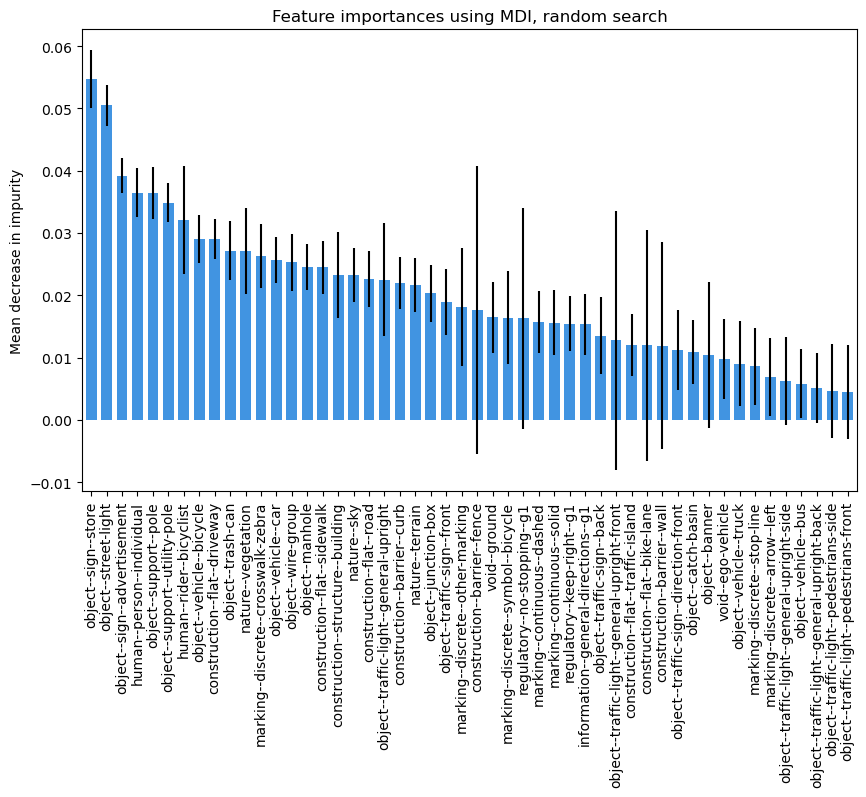

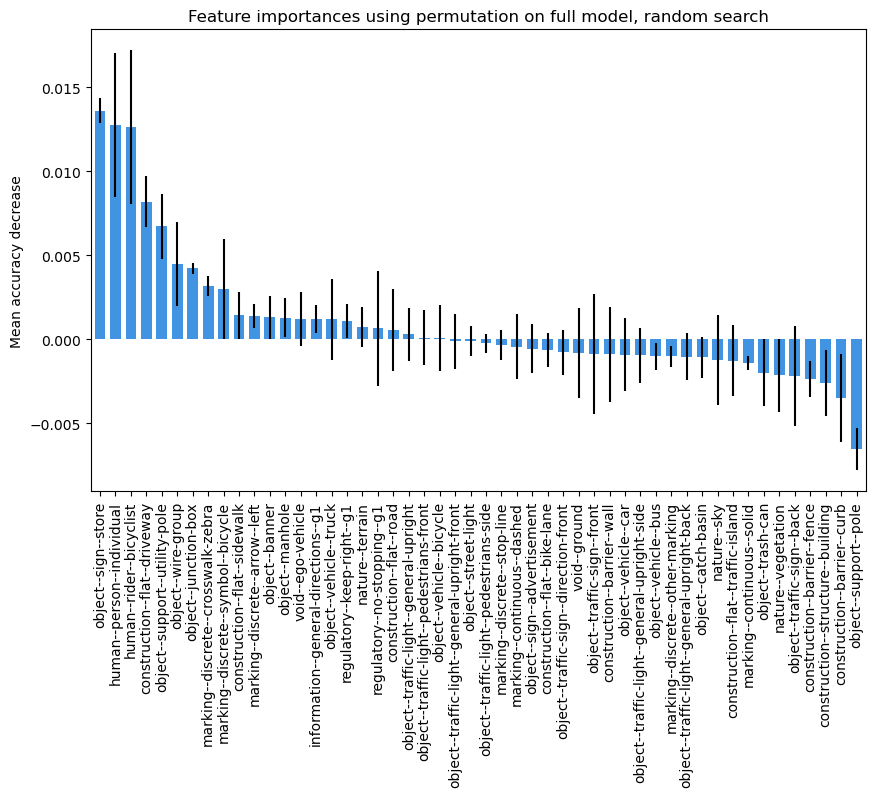

object--sign--store           0.014 +/- 0.004
human--person--individual     0.013 +/- 0.003
human--rider--bicyclist       0.013 +/- 0.003
construction--flat--driveway  0.008 +/- 0.002


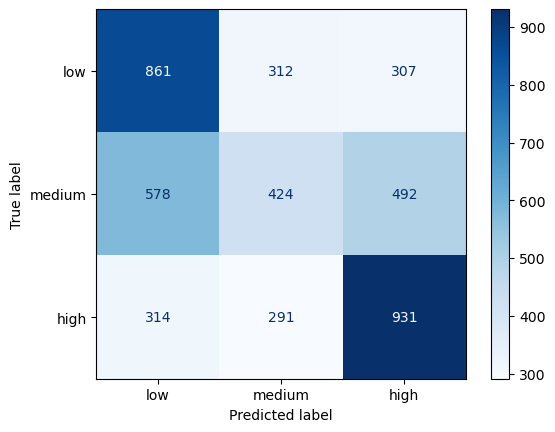

[0 1 2]


In [46]:
#split data

#define parameters

#random 

best_test = np.argmax(rfc_random.cv_results_['mean_test_score'])
#best_test_i = best_iteration_indices[best_test]
best_param = rfc_random.cv_results_['params'][best_test]

model_rand = RandomForestClassifier(**best_param,oob_score=True)
model_rand.fit(X_train, y_train)

y_pred_rand = model_rand.predict(X_test)

# Evaluate the model's performance on the test set
accuracy_rand = accuracy_score(y_test, y_pred_rand)
print("Test set accuracy:", accuracy_rand)
print("Out of bag score", model_rand.oob_score_)
print("Out of bag decision function", model_rand.oob_decision_function_)
print(len(model_rand.oob_decision_function_))
print(model_rand.get_params())

print("Confusion matrix random search: \n",  confusion_matrix(y_test,y_pred_rand))


print("Model feature importances:", sorted(model_rand.feature_importances_,reverse=True))
print("Model feature importances names:", [model_rand.feature_names_in_[i] for i in sorted(range(len(model_rand.feature_importances_)), key=lambda k: model_rand.feature_importances_[k], reverse=True)])


importances = model_rand.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rand.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names = sorted_importances.index  # Sorting the feature names based on importances

fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=std[sorted_importances.index.get_indexer(sorted_feature_names)], ax=ax, color=["#4194E1"],width =0.7)  # Using sorted importances and corresponding std
ax.set_title("Feature importances using MDI, random search")
ax.set_ylabel("Mean decrease in impurity")
plt.show()


from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_rand, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances_perm = pd.Series(result.importances_mean, index=feature_names)

sorted_importances_perm = forest_importances_perm.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names_perm = forest_importances_perm.index  # Sorting the feature names based on importances


#print(result)    
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances_perm.plot.bar(yerr=result.importances_std[sorted_importances_perm.index.get_indexer(sorted_feature_names_perm)], ax=ax, color=["#4194E1"], width =0.7)
ax.set_title("Feature importances using permutation on full model, random search")
ax.set_ylabel("Mean accuracy decrease")
plt.show()



for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{feature_names[i]:<30}"
               f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")
        
cm_rand = confusion_matrix(y_test, y_pred_rand, labels=model_rand.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rand,display_labels=["low","medium","high"])
disp.plot(cmap='Blues')
plt.show()

print(model_rand.classes_)

Test set accuracy: 0.4917960088691796
Out of bag score 0.49118625277161865
Out of bag decision function [[0.46071633 0.32673131 0.21255237]
 [0.34407112 0.35514115 0.30078772]
 [0.20715637 0.33719989 0.45564374]
 ...
 [0.11575818 0.37815657 0.50608526]
 [0.21614583 0.23648313 0.54737103]
 [0.50829724 0.41091613 0.08078663]]
18040
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 31, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 320, 'n_jobs': None, 'oob_score': True, 'random_state': None, 'verbose': 0, 'warm_start': False}
Confusion matrix gridsearch: 
 [[856 323 301]
 [569 450 475]
 [315 309 912]]
Model feature importances: [0.05559532252726753, 0.04863388012897939, 0.04034266336641847, 0.03802044901918051, 0.0359561994119963, 0.030624709937487032, 0.029595575496259217, 0.027009519474841474, 0.02

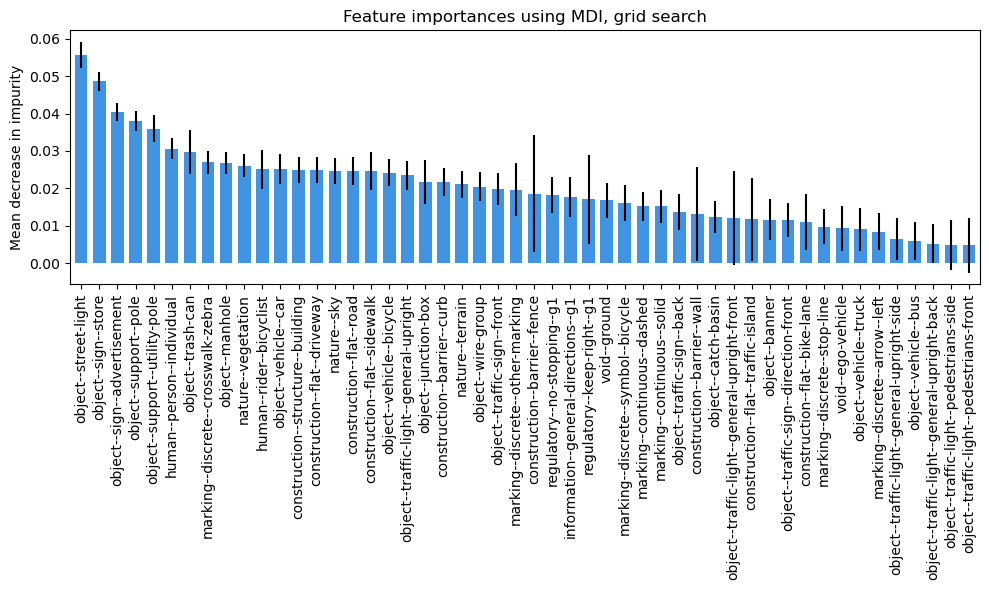

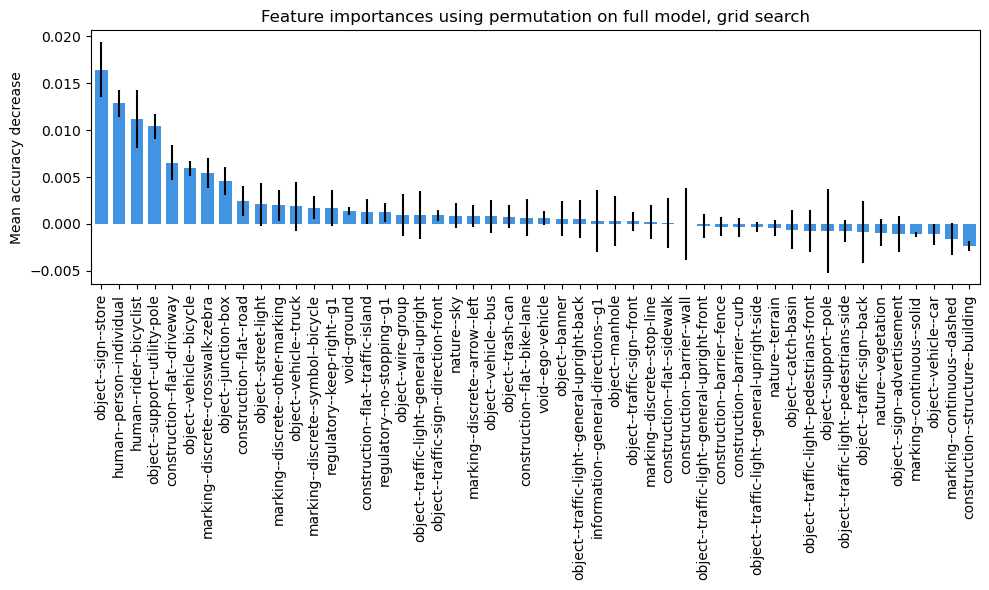

object--sign--store           0.016 +/- 0.004
human--person--individual     0.013 +/- 0.003
human--rider--bicyclist       0.011 +/- 0.003
object--support--utility-pole 0.010 +/- 0.004
construction--flat--driveway  0.007 +/- 0.002
object--vehicle--bicycle      0.006 +/- 0.002
object--junction-box          0.005 +/- 0.001


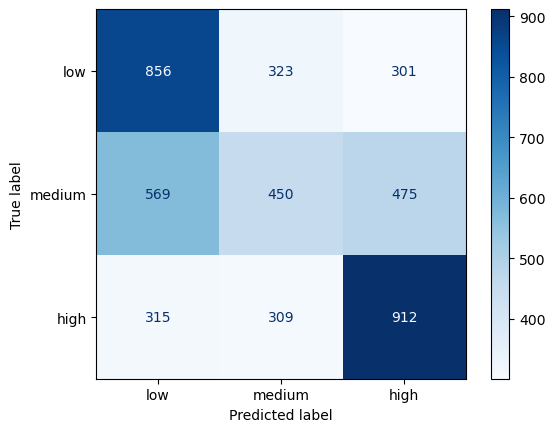

In [47]:
#Grid

best_test = np.argmax(rfc_grid.cv_results_['mean_test_score'])
#best_test_i = best_iteration_indices_grid[best_test]
best_param_grid = rfc_grid.cv_results_['params'][best_test]

model_grid = RandomForestClassifier(**best_param_grid,oob_score=True)
model_grid.fit(X_train, y_train)

y_pred_grid = model_grid.predict(X_test)

# Evaluate the model's performance on the test set
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print("Test set accuracy:", accuracy_grid)
print("Out of bag score", model_grid.oob_score_)
print("Out of bag decision function", model_grid.oob_decision_function_)
print(len(model_grid.oob_decision_function_))
print(model_grid.get_params())

print("Confusion matrix gridsearch: \n", confusion_matrix(y_test,y_pred_grid))

print("Model feature importances:", sorted(model_grid.feature_importances_,reverse=True))
print("Model feature importances names:", [model_grid.feature_names_in_[i] for i in sorted(range(len(model_rand.feature_importances_)), key=lambda k: model_rand.feature_importances_[k], reverse=True)])

importances = model_grid.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_grid.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
sorted_importances = forest_importances.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names = sorted_importances.index  # Sorting the feature names based on importances

fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(yerr=std[sorted_importances.index.get_indexer(sorted_feature_names)], ax=ax,color=["#4194E1"],width =0.7)  # Using sorted importances and corresponding std
ax.set_title("Feature importances using MDI, grid search")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


from sklearn.inspection import permutation_importance

result = permutation_importance(
    model_grid, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances_perm = pd.Series(result.importances_mean, index=feature_names)

sorted_importances_perm = forest_importances_perm.sort_values(ascending=False)  # Sorting the importances

sorted_feature_names_perm = forest_importances_perm.index  # Sorting the feature names based on importances


#print(result)    
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances_perm.plot.bar(yerr=result.importances_std[sorted_importances_perm.index.get_indexer(sorted_feature_names_perm)], ax=ax,color=["#4194E1"],width =0.7)
ax.set_title("Feature importances using permutation on full model, grid search")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()



for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{feature_names[i]:<30}"
               f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")
        
cm_grid = confusion_matrix(y_test, y_pred_grid, labels=model_grid.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_grid,display_labels=["low","medium","high"])
disp.plot(cmap='Blues')
plt.show()

In [48]:


n_samples = 100

baseline_score = []

for i in range(0,n_samples):
    
    boot_sample = list(np.random.choice(y_test,size=len(y_test),replace=True))
    
    low = boot_sample.count(0)
    med = boot_sample.count(1)
    high = boot_sample.count(2)
    
    freq = [low/len(y_test),med/len(y_test),high/len(y_test)]
    most_freq = max(freq)
    baseline_score.append(most_freq)

#print(np.mean(baseline_score))
interval = st.t.interval(confidence=0.95, df=len(baseline_score)-1, loc=np.mean(baseline_score), scale=st.sem(baseline_score)) 

print("The accuracy of the random model is:", accuracy_rand)
print("The accuracy of the grid model is:", accuracy_grid)
print("The confidence interval of the baseline is:", interval)
print("The mean of the accuracy of the baseline is:", np.mean(baseline_score))


if interval[0] <= accuracy_rand <= interval[1]:
    print("The accuracy of the random model is within the confidence interval for the baseline")
elif accuracy_rand <= interval[0]:
    print("The accuracy of the random model is worse than the baseline")
else:
    print("The accuracy of the random model is is higher than the upper confidence interval for the baseline \n and thereby performs better")


    
if interval[0] <= accuracy_grid <= interval[1]:
    print("The accuracy of the grid model is within the confidence interval for the baseline")
elif accuracy_grid <= interval[0]:
    print("The accuracy of the grid model is worse than the baseline")
else:
    print("The accuracy of the grid model is higher than the upper confidence interval for the baseline \n and thereby performs better")




The accuracy of the random model is: 0.49135254988913524
The accuracy of the grid model is: 0.4917960088691796
The confidence interval of the baseline is: (0.34098888591390386, 0.34290911852068584)
The mean of the accuracy of the baseline is: 0.34194900221729485
The accuracy of the random model is is higher than the upper confidence interval for the baseline 
 and thereby performs better
The accuracy of the grid model is higher than the upper confidence interval for the baseline 
 and thereby performs better
